# GRU

# Preprocessing

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import io
import re
import string
import tqdm

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

2022-10-31 16:10:51.904831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 16:10:51.904856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-31 16:10:54.281286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:10:54.282048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 16:10:54.282175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./data/text_emotion.csv")

Getting embeddings using Word2Vec. Word2vec has 2 algorithms, 
1. Continuous Bag of words
    - word is predicted from context "__ my name is Kevin"
2. Skip Gram
    - context is predicted from target "Hi __ __ __ __"

In [4]:
df.head(20)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


## Data Cleaning
1. Getting rid of the punctuations marks from dataset
2. converting all content to lowercase

In [5]:
cleaned_df = df.copy()
cleaned_df['content'] = cleaned_df['content'].str.replace(r'[^\w\s]','',regex=True)
cleaned_df['content'] = cleaned_df['content'].str.lower()

The cleaned data looks like this. 
now we want to find the number of unique words to rationalise the size of a embedding vector
We also want to find the maximum number of words in a sentence

In [6]:
cleaned_df.head(100)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part
1,1956967666,sadness,wannamama,layin n bed with a headache ughhhhwaitin on your call
2,1956967696,sadness,coolfunky,funeral ceremonygloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon
4,1956968416,neutral,xkilljoyx,dannycastillo we want to trade with someone who has houston tickets but no one will
...,...,...,...,...
95,1956989514,sadness,yellowduckx,sweeetnspicy hiii im on my ipodi cant fall asleep
96,1956989526,sadness,KaKuBby,dont wanna work 11830 tomorrow but i get paid
97,1956989560,sadness,benchidol,feels sad coz i wasnt able to play with the guys httpplurkcompwxiux
98,1956989561,neutral,outrAjusCharmer,princecharming


In [7]:
max_sentence_len = cleaned_df['content'].str.len().max()
sentence_size = cleaned_df['content'].apply(lambda content: len(content.split())).sum()

print("max sentence length of content is {}".format(max_sentence_len))
print("total sentence size of content is {}".format(sentence_size))

max sentence length of content is 151
total sentence size of content is 522948


So our input vocab size must be at least 151 to fully take in 1 sentence <br>
Since it is computationally heavy to have a vector of 522948 in size. <br>
We will use a vector of only 256, meaning that in the bag of words algorithm, the words will only take 255 other context words as input

## Getting Continuous vectors (Embeddings) for words in using Skip-gram in Word2Vec

In [17]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for sentence in cleaned_df['content'].str.split():
    for token in sentence:
        if token not in vocab:
            vocab[token] = index
            index += 1
vocab_size = len(vocab)

{'<pad>': 0, 'tiffanylue': 1, 'i': 2, 'know': 3, 'was': 4, 'listenin': 5, 'to': 6, 'bad': 7, 'habit': 8, 'earlier': 9, 'and': 10, 'started': 11, 'freakin': 12, 'at': 13, 'his': 14, 'part': 15, 'layin': 16, 'n': 17, 'bed': 18, 'with': 19, 'a': 20, 'headache': 21, 'ughhhhwaitin': 22, 'on': 23, 'your': 24, 'call': 25, 'funeral': 26, 'ceremonygloomy': 27, 'friday': 28, 'wants': 29, 'hang': 30, 'out': 31, 'friends': 32, 'soon': 33, 'dannycastillo': 34, 'we': 35, 'want': 36, 'trade': 37, 'someone': 38, 'who': 39, 'has': 40, 'houston': 41, 'tickets': 42, 'but': 43, 'no': 44, 'one': 45, 'will': 46, 'repinging': 47, 'ghostridah14': 48, 'why': 49, 'didnt': 50, 'you': 51, 'go': 52, 'prom': 53, 'bc': 54, 'my': 55, 'bf': 56, 'like': 57, 'should': 58, 'be': 59, 'sleep': 60, 'im': 61, 'not': 62, 'thinking': 63, 'about': 64, 'an': 65, 'old': 66, 'friend': 67, 'hes': 68, 'married': 69, 'now': 70, 'damn': 71, 'amp': 72, 'he': 73, 'me': 74, '2': 75, 'scandalous': 76, 'hmmm': 77, 'httpwwwdjherocom': 78, '

In [18]:
inverse_vocab = {index: token for token, index in vocab.items()}\

{0: '<pad>', 1: 'tiffanylue', 2: 'i', 3: 'know', 4: 'was', 5: 'listenin', 6: 'to', 7: 'bad', 8: 'habit', 9: 'earlier', 10: 'and', 11: 'started', 12: 'freakin', 13: 'at', 14: 'his', 15: 'part', 16: 'layin', 17: 'n', 18: 'bed', 19: 'with', 20: 'a', 21: 'headache', 22: 'ughhhhwaitin', 23: 'on', 24: 'your', 25: 'call', 26: 'funeral', 27: 'ceremonygloomy', 28: 'friday', 29: 'wants', 30: 'hang', 31: 'out', 32: 'friends', 33: 'soon', 34: 'dannycastillo', 35: 'we', 36: 'want', 37: 'trade', 38: 'someone', 39: 'who', 40: 'has', 41: 'houston', 42: 'tickets', 43: 'but', 44: 'no', 45: 'one', 46: 'will', 47: 'repinging', 48: 'ghostridah14', 49: 'why', 50: 'didnt', 51: 'you', 52: 'go', 53: 'prom', 54: 'bc', 55: 'my', 56: 'bf', 57: 'like', 58: 'should', 59: 'be', 60: 'sleep', 61: 'im', 62: 'not', 63: 'thinking', 64: 'about', 65: 'an', 66: 'old', 67: 'friend', 68: 'hes', 69: 'married', 70: 'now', 71: 'damn', 72: 'amp', 73: 'he', 74: 'me', 75: '2', 76: 'scandalous', 77: 'hmmm', 78: 'httpwwwdjherocom', 7

trying out vectorizing a single sentence in the dataset. of course we actually need to vectorize multiple sentences

In [23]:
cleaned_df['content_vector'] = cleaned_df['content'].apply(lambda sentence: [vocab[word] for word in sentence.split()])

Generating skip grams for our vectors with a window size of 2 for the single sentence

In [58]:
# window size is 2 currently, which is fairly local, can improve the vectors to
# take into account words that are further away by increasing window size
# ideally we want to increase window size to 151, the max size of the sentence
# to ensure that the words will take into account the entire sentence
window_size =2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      cleaned_df['content_vector'][0],
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)
print(len(positive_skip_grams))

62


Visualising some skip grams(predicted contexts to see what they look like)

In [59]:
print('original sentence: {}'.format(cleaned_df['content'][0]))
for target, context in positive_skip_grams[:10]:
    print('(target = {},context =  {}): ({}, {})'.format(target,context,inverse_vocab[target],inverse_vocab[context]))

original sentence: tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part 
(target = 10,context =  9): (and, earlier)
(target = 2,context =  3): (i, know)
(target = 2,context =  9): (i, earlier)
(target = 7,context =  8): (bad, habit)
(target = 5,context =  4): (listenin, was)
(target = 14,context =  13): (his, at)
(target = 2,context =  12): (i, freakin)
(target = 5,context =  6): (listenin, to)
(target = 3,context =  1): (know, tiffanylue)
(target = 10,context =  11): (and, started)


Construct a negative sampling for one-skip gram. To produce negative samples for training, we randomly sample words from the same sentence usin the tf.random.log_uniform_candidate_sampler function to sample a number of 10 samples(as suggested by documentation of tensorflow for sampling small dataset). We exclude the skip-gram's target word from being sampled by passing the context words as true

In [37]:
target_word, context_word = positive_skip_grams[0]

In [63]:
num_ns = 10

context_class = tf.reshape(tf.constant(context_word, dtype='int64'),(1,1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=SEED,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)


In [64]:
negative_sampling_candidates
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

['separate', 'hungrygirl', 'listenin', 'whole', 'bury', 'tiffanylue', 'alexlomas', 'sure', 'thatchmaster', 'choked']


In [67]:
# Reduce a dimension so you can use concatenation (in the next step).
squeezed_context_class = tf.squeeze(context_class, 1)
print(squeezed_context_class)
# Concatenate a positive context word with negative sampled words.
context = tf.concat([squeezed_context_class, negative_sampling_candidates], 0)

# Label the first context word as `1` (positive) followed by `num_ns` `0`s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64")
target = target_word

tf.Tensor([[9]], shape=(1, 1), dtype=int64)
tf.Tensor([9], shape=(1,), dtype=int64)


Combine the steps to one function

In [78]:
def generate_training_data(sequences, window_size,num_ns,vocab_size,seed):
    
    # each training sentence is appended to these list
    targets,contexts,labels = [],[],[]
    
    # sampling table for vocab_size tokens
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # iterate over all sentences in dataset
    for sequence in tqdm.tqdm(sequences):
       

        # generating positive skip-gram pairs for a sequence
        positive_skip_grams,_ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size = vocab_size,
            sampling_table=sampling_table,
            window_size=window_size, # TODO: change window size
            negative_samples=0
        )
        
        # produce negative samples and create training samples (x_train,labels)
        for target_word, context_word in positive_skip_grams:
    
    
            # expand context word to frmo dim shape (1,0) to (1,1)
            context_class = tf.expand_dims(
                tf.constant([context_word],dtype='int64'),1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class, # to tell the which sample is positive
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size, #TODO: may need to change to just the negative samples of the sentence itself instead of the entire vocab
                seed=seed,
                name='negative_sampling')
    
    
            # building the context and label vectors for a target word
            context = tf.concat([tf.squeeze(context_class,1),negative_sampling_candidates],0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")
    
    
            # append each element from the training ex to global lists
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
    
    return targets, contexts, labels 
            
            

## Preparing training data for word2vec

In [79]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

In [83]:
# size of one sentence is 151 but we just use 256
sequence_length = 256

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [73]:
cleaned_df.head()

,tweet_id,sentiment,author,content,content_vector
0,1956967341,empty,xoshayzers,tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part,"[1, 2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 2, 11, 12, 13, 14, 15]"
1,1956967666,sadness,wannamama,layin n bed with a headache ughhhhwaitin on your call,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25]"
2,1956967696,sadness,coolfunky,funeral ceremonygloomy friday,"[26, 27, 28]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon,"[29, 6, 30, 31, 19, 32, 33]"
4,1956968416,neutral,xkilljoyx,dannycastillo we want to trade with someone who has houston tickets but no one will,"[34, 35, 36, 6, 37, 19, 38, 39, 40, 41, 42, 43, 44, 45, 46]"


In [91]:
# TODO change to smaller batch for better results
batch_size = 1024

In [92]:
# creating a dataset of all sentences
text_ds = tf.data.Dataset.from_tensor_slices(df['content'])
# for item in text_ds.as_numpy_iterator():
#     print (item)
vectorize_layer.adapt(text_ds.batch(batch_size))

In [93]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'it', 'is', 'in', 'for', 'of', 'im', 'on', 'me', 'have', 'so', 'that']


In [95]:
# Vectorize the data in text_ds.
# prefetch does fetching of data and training at the same time using multiple thread
# improving performance
text_vector_ds = text_ds.batch(batch_size).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [96]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))
# hmmm why is this 40000 and not equal to the vocab size of 50k+

40000


In [97]:
for seq in sequences[:5]:
    print("{} => {}".format(seq,[inverse_vocab[i] for i in seq]))

[19127     2    55     2    27  3241     3   119  5589   811     7     2
   580  1112    26   172   522     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [98]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:53<00:00, 748.38it/s]




targets.shape: (386421,)
contexts.shape: (386421, 5)
labels.shape: (386421, 5)


Configuring training sets for Word2Vec model

In [99]:
BATCH_SIZE = batch_size
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [100]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [101]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
              embedding_dim,
              input_length=1,
              name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
               embedding_dim,
               input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [102]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [104]:
# embedding size for word2vec lets try 256 since it is more than a sentence
embedding_dim = 256
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
# call back to log training stats for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [105]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20


2022-10-31 18:01:01.286154: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55108608 exceeds 10% of free system memory.
2022-10-31 18:01:01.302712: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55108608 exceeds 10% of free system memory.
2022-10-31 18:01:01.309440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55108608 exceeds 10% of free system memory.
2022-10-31 18:01:01.321018: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55108608 exceeds 10% of free system memory.
2022-10-31 18:01:01.339793: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 55108608 exceeds 10% of free system memory.


377/377 [==============================] - 91s 241ms/step - loss: 1.5786 - accuracy: 0.2711
Epoch 2/20
377/377 [==============================] - 97s 258ms/step - loss: 1.3773 - accuracy: 0.5557
Epoch 3/20
377/377 [==============================] - 97s 259ms/step - loss: 1.0830 - accuracy: 0.6985
Epoch 4/20
377/377 [==============================] - 97s 258ms/step - loss: 0.7867 - accuracy: 0.8118
Epoch 5/20
377/377 [==============================] - 98s 259ms/step - loss: 0.5663 - accuracy: 0.8716
Epoch 6/20
377/377 [==============================] - 100s 266ms/step - loss: 0.4171 - accuracy: 0.9060
Epoch 7/20
377/377 [==============================] - 98s 260ms/step - loss: 0.3185 - accuracy: 0.9296
Epoch 8/20
377/377 [==============================] - 97s 257ms/step - loss: 0.2523 - accuracy: 0.9454
Epoch 9/20
377/377 [==============================] - 97s 256ms/step - loss: 0.2064 - accuracy: 0.9559
Epoch 10/20
377/377 [==============================] - 97s 258ms/step - loss: 0.173

Embedding lookup and analysis

In [106]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [108]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

## Brief description of method used

Tokenisation -> turning each word into a number, this is ok but the high numbers on a word is not so good for machine learning
i.e. (1, aardvark), (123,you), the 123 not so good for machine learning

A better way is to convert words into one hot vectors. in one hot vectors, each word is a *unit* vector in its own dimensionaxis and is at 90 degree from all other vectors
i.e. aardvark -> [1,0,0,0,0,... n ], where n is the number of words in the training dataset, and you - >[0,0,0,...1,...] -> bad thing about this is that the dimension of a one-hot vector = number of distinct words in the dataset/corpus, it could be very large.
drawback of one hot encoding? the words might not be perfectly a unit vector and might have relations with other words. A even better way is to represent the words as a *continuous* vector in N-dimentional space

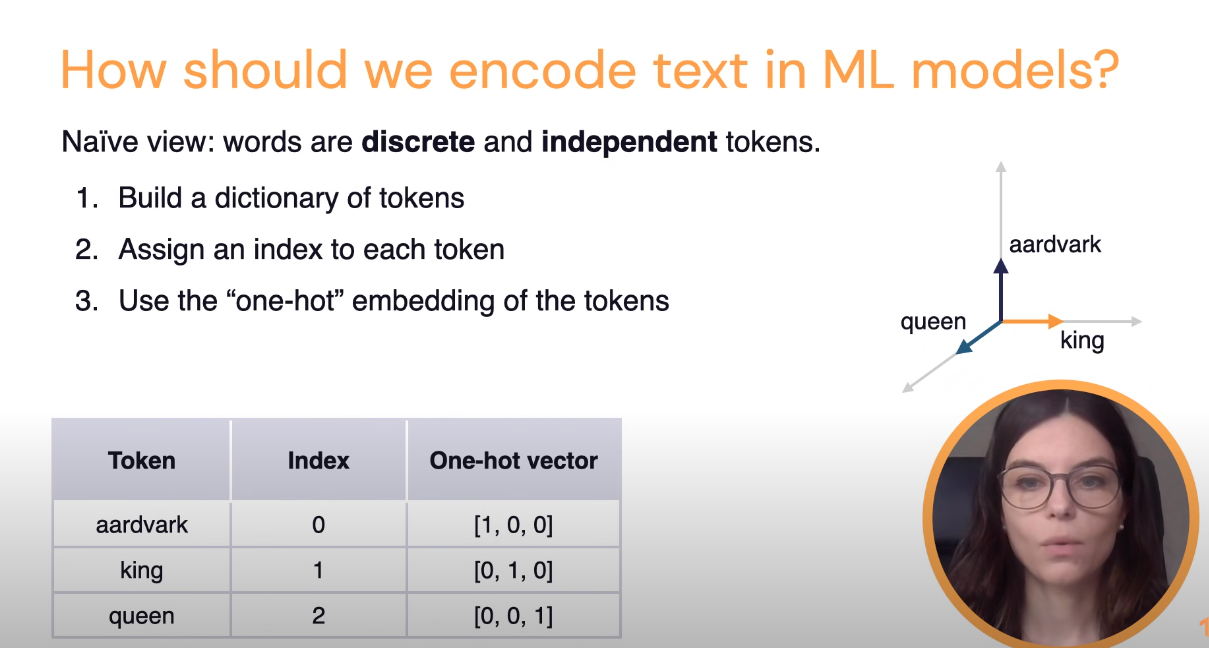

Continous vector in N-dimensional space. vector has more realistic values (also called continuous embeddings)

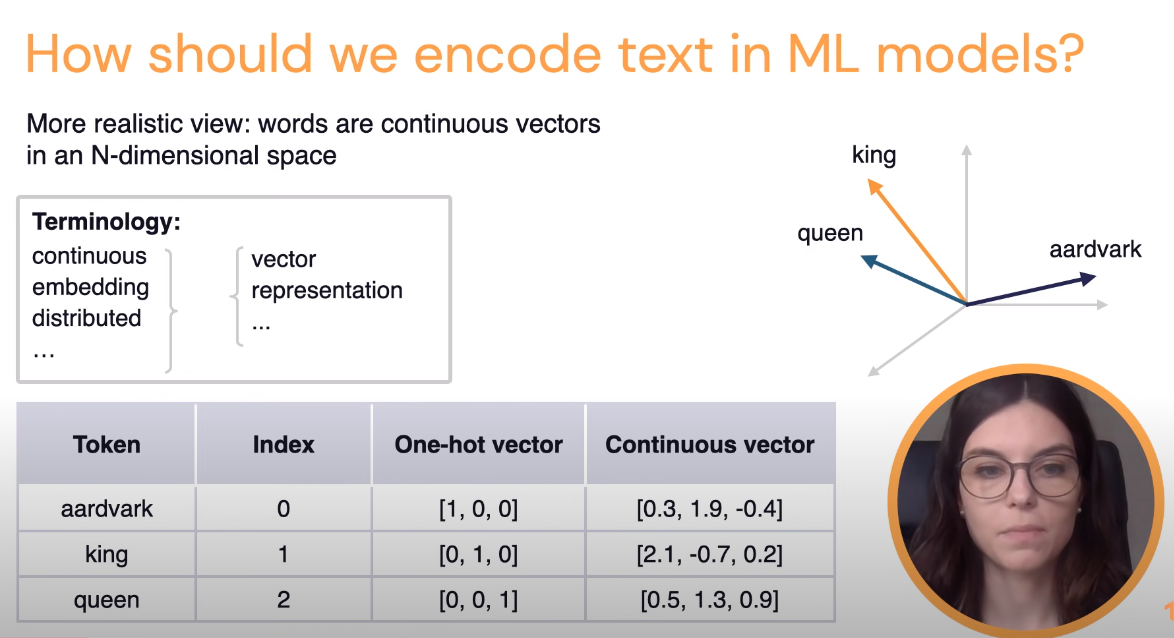

How does vectors work in telling how similar/different the token is? we use relative vector distance
i.e.
case 1: in the 3 dimensional graph of the gender dimension, the vectors representing "man" and "woman" are far apart, this shows that the tokens are very different.
However in the 3 dimension of part-of-speech, they are quite close together because they are all "nouns"
We aim for the continuous embeddings to display such qualities.

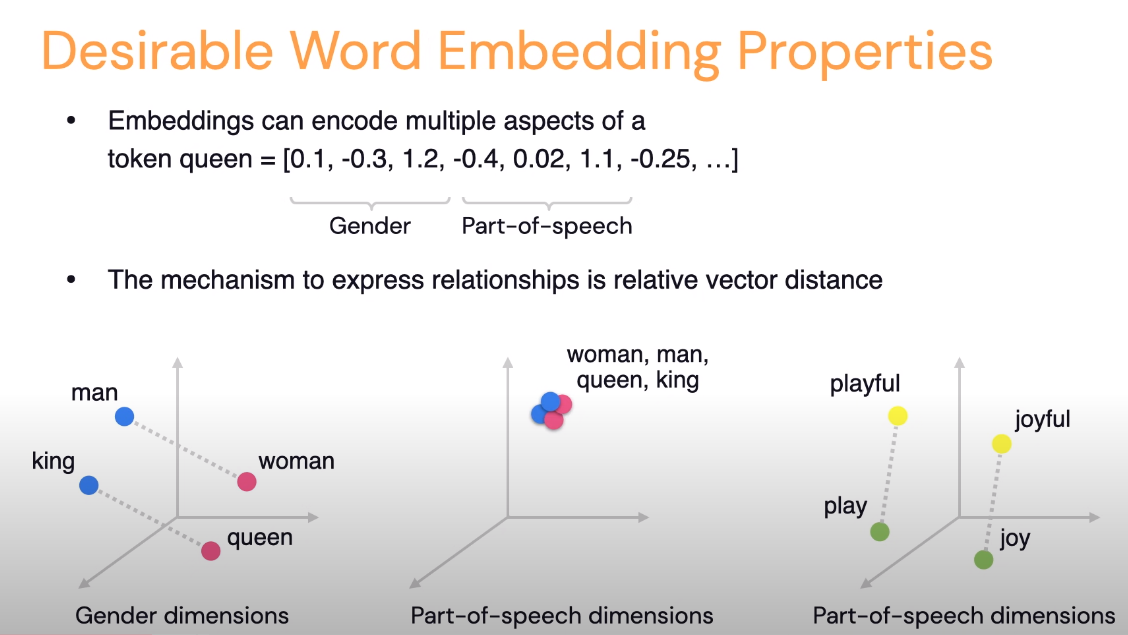

Notes:
1. Word2Vec

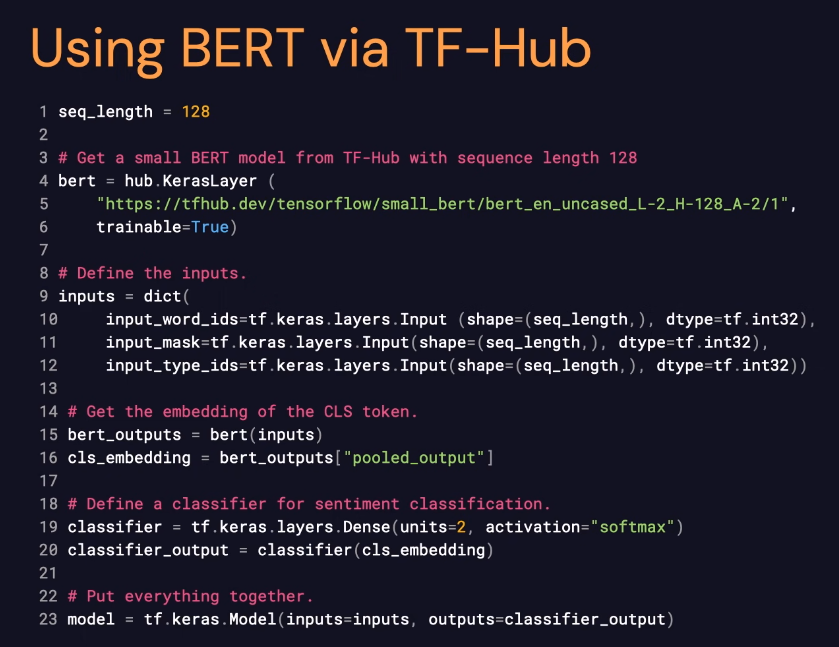

A problem with Word2Vec embeddings is that in the embedding a single word is mapped to all contexts, whereas in reality that is not the case
i.e. river bank vs UOB bank, the banks referred here have totally different meanings, but in the model it is mapped to the same vector

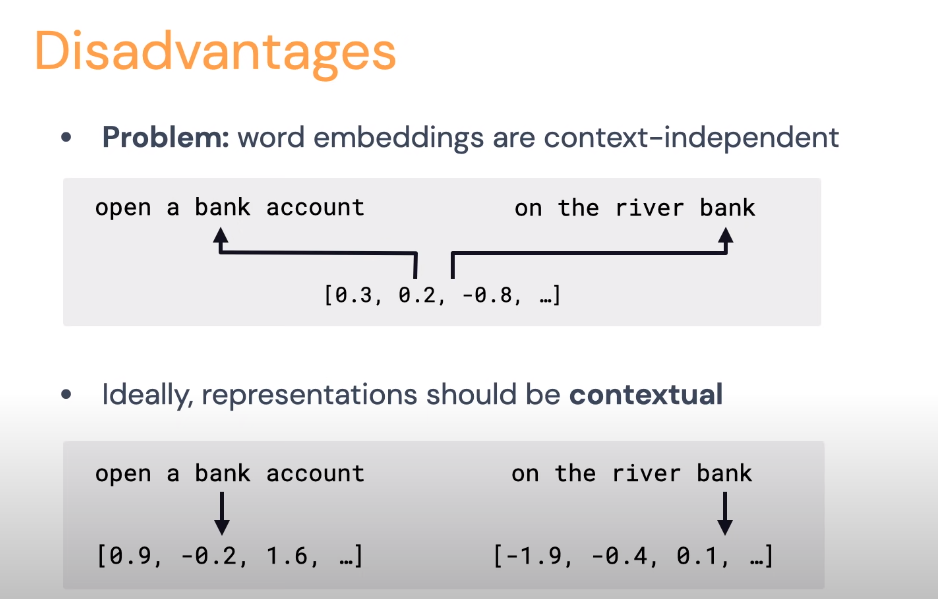

In RNN, we can start with a Non-contextual embeddings X_i (word2Vec) which cna be looked up in a table.
RNN takes input from previous hidden states in the sentence, thus the current embedding will be trained on the "context" on the previous words. The result from an  RNN during training is a new corpus with new continous vectors containing contextual meaning

Disadvantages, 
RNN is quite slow and cannot be parallised is because the current word requires all previous sequences
RNN has a vanishing gradient problem where words further away from the current predicited word will be considered less in thhe context
RNN is processes words unidirectionally, left to right, which is very unlike humans
i.e. "on the river bank"
if rnn processed this it will take the relevant context of the river into account for prediction of bank
however if this sentence is used "on the bank of the river" the relevant ccontext of "river" which was used for bank came after "bank". making predictions less accurate (model might think it means the financial institution bank) due to the absence of the "river" context
Transformers solve this problem by teaching the model to take context both from the left hand side and the right hand side.

# LSTM implementation

# Experiments and results